# Creating a Kaggle Workflow

In this guided project, I am going to put together all that we've learned in this course and create a data science workflow.

Data science, and particularly machine learning, contain many dimensions of complexity when compared with standard software development. In this mission, I am going to explore a workflow to make competing in the Kaggle 'Titanic' competition easier, using a pipeline of functions to reduce the number of dimensions I will need to focus on.

The Kaggle workflow we are going to build will combine all of these into a process.

In [1]:
from IPython.display import Image
Image("/Users/miesner.jacob/Desktop/DataQuest/Titanic Kaggle Competition/kaggle_workflow.png")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

train = pd.read_csv('/Users/miesner.jacob/Desktop/DataQuest/Titanic Kaggle Competition/train.csv')
test = pd.read_csv('/Users/miesner.jacob/Desktop/DataQuest/Titanic Kaggle Competition/test.csv')

## Data Exploration

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [7]:
#ulility functions

def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def prep(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df,'Age_categories')
    df = create_dummies(df,'Fare_categories')
    df = create_dummies(df,'Title')
    df = create_dummies(df,'Cabin_type')
    df = create_dummies(df,'Sex')
    
    return df

In [8]:
train = prep(train)
test = prep(test)

In [9]:
people_cols = ["SibSp","Parch", 'Survived']
explore = train[people_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


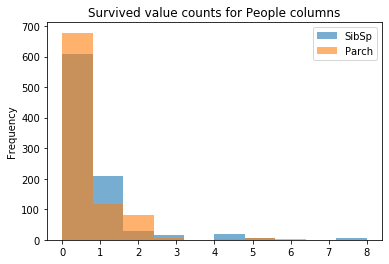

In [10]:
explore.drop("Survived",axis=1).plot.hist(alpha=0.6)
plt.title('Survived value counts for People columns')
plt.show()

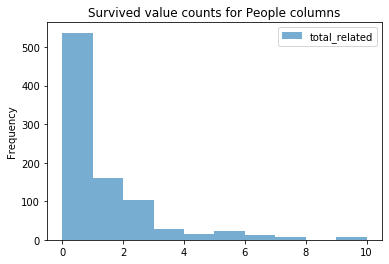

In [11]:
explore["total_related"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop(people_cols,axis=1).plot.hist(alpha=0.6,bins=10)
plt.title('Survived value counts for People columns')
plt.show()

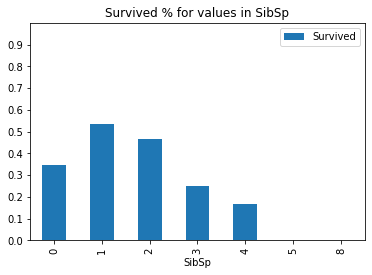

In [12]:
pivot = explore.pivot_table(index='SibSp',values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.title('Survived % for values in SibSp')
plt.show()

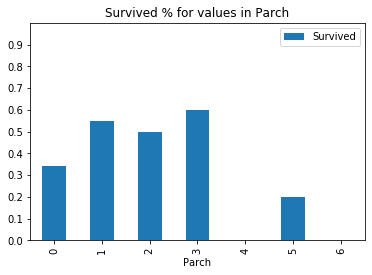

In [13]:
pivot = explore.pivot_table(index='Parch',values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.title('Survived % for values in Parch')
plt.show()

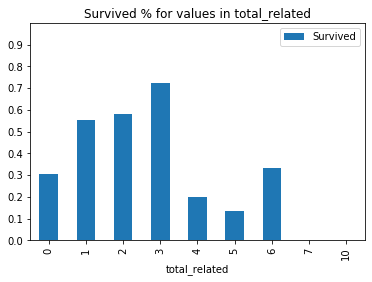

In [14]:
pivot = explore.pivot_table(index='total_related',values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.title('Survived % for values in total_related')
plt.show()

## Feature Engineering & Feature Selection

In [15]:
def add_isalone_feature(df):
    df['total_realted'] = df['SibSp'] + df['Parch']
    df['isalone'] = ''
    df.loc[df['total_realted'] == 0, 'isalone'] = 1
    df.loc[df['total_realted'] != 0, 'isalone'] = 0
    df.drop('isalone', axis=1)
    
    return df

In [16]:
train = add_isalone_feature(train)
test = add_isalone_feature(test)

In [17]:
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    optimized_columns = all_X.columns[selector.support_]
    print(optimized_columns)
    
    return list(optimized_columns)

In [18]:
cols = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'total_realted'],
      dtype='object')


## Model Selection

In [30]:
def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(max_iter=1000),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        },
        {
            "name": "GradientBoostingClassifier",
            "estimator": GradientBoostingClassifier(),
            "hyperparameters":
                {
                    'max_depth': [5,10,50], 
                    'min_samples_leaf': [2,5,10],
                    'learning_rate': [0.1,0.25,0.5],
                    'subsample': [0.1,0.25,0.5],
                    'min_samples_leaf': [2,10,25], 
                    'loss': ['deviance','exponential']
                }
        }
    ]
    
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
        grid = GridSearchCV(estimator = model['estimator'], param_grid = model['hyperparameters'], scoring = 'accuracy', cv = 10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models
                                                                                      

In [31]:
result = select_model(train,cols)

LogisticRegression
------------------
Best Score: 0.821598002496879
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.7822971285892635
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8350686641697876
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}

GradientBoostingClassifier
--------------------------
Best Score: 0.8417602996254681
Best Parameters: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'min_samples_leaf': 25, 'subsample': 0.5}



In [32]:
def save_submission_file(model,cols):
    predictions = model.predict(test[cols])
    submission_dict = {'PassengerId': test['PassengerId'], 'Survived': predictions}
    submission = pd.DataFrame(submission_dict)
    submission.to_csv('/Users/miesner.jacob/Desktop/DataQuest/Projects/Titanic Kaggle Competition/submission_5.csv', index=False)

In [33]:
final_model = result[3]["best_model"]
save_submission_file(final_model, cols)

In [ ]:
fina